# Storm Data Visualization

## Big Data Applications - Fall 2018

### Indiana University

### Class: E523 | Group: fa18-523-57, fa18-523-58

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importing Data stored in Azure Cosmos DB

In [4]:
# Reading uri path from a file
config_file = open('cosmos_db.config','r')
uri_path = config_file.read()
client = pymongo.MongoClient(uri_path)

#### Give the client and collection names

In [5]:
db = client['test']
collection = db['storm_data']

### Pull Data from DB cloud

In [6]:
from time import time
t0 = time()
data = pd.DataFrame(list(collection.find()))
print('Completed in ', np.round(time() - t0,3) , ' seconds')


Completed in  3.095  seconds


In [7]:
data.shape, data.drop_duplicates().shape

((191716, 13), (131194, 13))

### Check the data

In [8]:
data.head()

,REGION,STORM_NO,NAME,ADVISORY,ADV_DATE,ADV_HOUR,SPEED,PRESSURE,TYPE,LAT,LONG_,LEN,geometry
0,S,0,1997-12-02,0,1997-12-03,18,25,0,D,-8.6,0.0,24916.158492,None
1,I,0,1979-02-11,0,1979-02-11,12,-999,0,D,-16.4,0.0,120480.811401,None
2,A,6,FIFI,0,1958-09-06,6,65,0,S,15.6,-55.7,218179.688965,None
3,A,6,FRANCES,0,2004-09-02,0,120,939,H,22.2,-71.4,121127.729658,None
4,A,9,HELENE,0,1988-09-27,18,77,979,H,30.9,-51.9,141631.071665,None


### Taking the relevant columns

In [9]:
data["LONG"] = data["LONG_"]
data = data[["ADV_DATE", "ADV_HOUR", "LAT", "LONG", "NAME", "PRESSURE", "REGION", "SPEED", "TYPE", "LEN"]]
data.reset_index()
data.head()

,ADV_DATE,ADV_HOUR,LAT,LONG,NAME,PRESSURE,REGION,SPEED,TYPE,LEN
0,1997-12-03,18,-8.6,0.0,1997-12-02,0,S,25,D,24916.158492
1,1979-02-11,12,-16.4,0.0,1979-02-11,0,I,-999,D,120480.811401
2,1958-09-06,6,15.6,-55.7,FIFI,0,A,65,S,218179.688965
3,2004-09-02,0,22.2,-71.4,FRANCES,939,A,120,H,121127.729658
4,1988-09-27,18,30.9,-51.9,HELENE,979,A,77,H,141631.071665


In [10]:
data.shape, data.drop_duplicates().shape

((191716, 10), (131142, 10))

### Drop Duplicate Values

In [11]:
data = data.drop_duplicates()
data.shape

(131142, 10)

### Check unique Storm Types and Regions in the data

In [12]:
data.TYPE.drop_duplicates(), data.REGION.drop_duplicates()

(0            D
 2            S
 3            H
 61           U
 183200    None
 Name: TYPE, dtype: object, 0     S
 1     I
 2     A
 10    W
 18    E
 Name: REGION, dtype: object)

### Check the Storm Names

In [13]:
pd.DataFrame(data["NAME"].drop_duplicates()).head()

,NAME
0,1997-12-02
1,1979-02-11
2,FIFI
3,FRANCES
4,HELENE


### Remove invalid storm names and their data

In [14]:
## Assigning a constant value to storms which do not have names
for i in range(10):
    data.loc[data.NAME.str.contains(str(i), na = False, case = False), "NAME"] = "None"

data = data[data.NAME != "None"]

### Check for Null values in each of the columns

In [15]:
data[data.TYPE.isna() == True].shape

(3, 10)

In [16]:
data = data[data.TYPE.isna() == False]
data = data[(data.TYPE == 'D') | (data.TYPE == 'H') | (data.TYPE == 'S') | (data.TYPE == 'U')]

In [17]:
data.drop_duplicates().shape

(84135, 10)

In [18]:
len(data[data.REGION.isna() == True]), len(data[data.NAME.isna() == True]), len(data[data.SPEED.isna() == True])

(0, 0, 0)

In [19]:
len(data[data.PRESSURE.isna() == True]), len(data[data.TYPE.isna() == True]), len(data[data.LAT.isna() == True]), len(data[data.LONG.isna() == True])

(0, 0, 0, 0)

### Split the Date column into Year, Month, and Day - Get relevant columns

In [20]:
## Split date into days, months and years
data['ADV_DATE'] = pd.to_datetime(data['ADV_DATE'])
data['YEAR'] = data['ADV_DATE'].dt.year
data['MONTH'] = data['ADV_DATE'].dt.month
data['DAY'] = data['ADV_DATE'].dt.day

data = data[['REGION', 'NAME', 'YEAR', 'MONTH', 'DAY', "ADV_HOUR", 'LAT', 'LONG', 'SPEED', 'PRESSURE', 'TYPE', "LEN"]]

### Describe data to see each column statistics

In [21]:
data.describe()

,YEAR,MONTH,DAY,ADV_HOUR,LAT,LONG,SPEED,PRESSURE,LEN
count,84135.000000,84135.000000,84135.000000,84135.000000,84135.000000,84135.000000,84135.000000,84135.000000,8.413500e+04
mean,1986.769537,8.191371,16.023201,9.158032,18.933107,-5.751068,56.077554,244.403589,1.216699e+05
std,16.115950,2.175004,8.760373,6.728276,11.091421,52.511555,33.982892,429.644786,1.019186e+05
min,1956.000000,1.000000,1.000000,0.000000,-34.400000,-179.900000,0.000000,0.000000,0.000000e+00
25%,1973.000000,7.000000,8.000000,6.000000,13.600000,0.000000,35.000000,0.000000,6.448334e+04
50%,1988.000000,8.000000,16.000000,12.000000,18.200000,0.000000,50.000000,0.000000,1.069043e+05
75%,2000.000000,10.000000,23.000000,18.000000,24.700000,0.000000,75.000000,0.000000,1.551886e+05
max,2017.000000,12.000000,31.000000,60.000000,70.700000,179.900000,999.000000,9830.000000,3.062178e+06


#### We see that the storm data ranges from the year 1956 to 2017

In [28]:
data[data.PRESSURE == 0].shape, data[data.PRESSURE == 98].shape, data[data.PRESSURE == 500].shape, data[data.PRESSURE == 1975].shape, data[data.PRESSURE == 9440].shape, data[data.PRESSURE == 9830].shape

((63405, 12), (1, 12), (1, 12), (1, 12), (1, 12), (1, 12))

### Assign hour 60 as hour 0

In [23]:
data.loc[data.ADV_HOUR == 60, "ADV_HOUR"] = 0

### Basic Histogram of the data

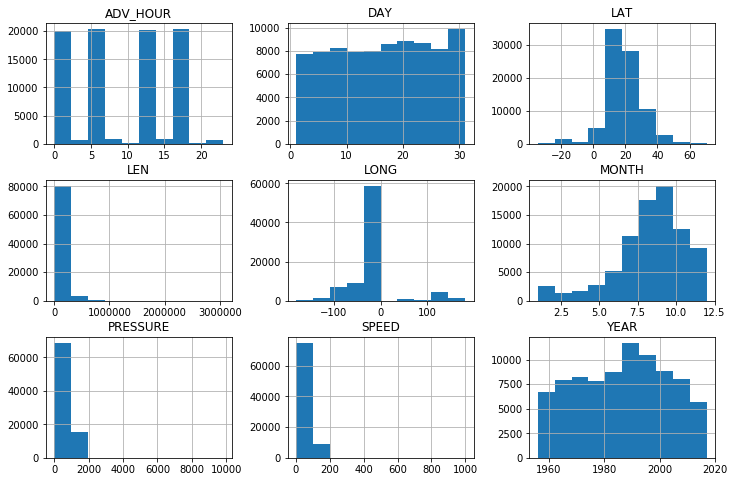

In [24]:
data.hist(figsize=(12,8));

### Plot of Unique Storms per Year

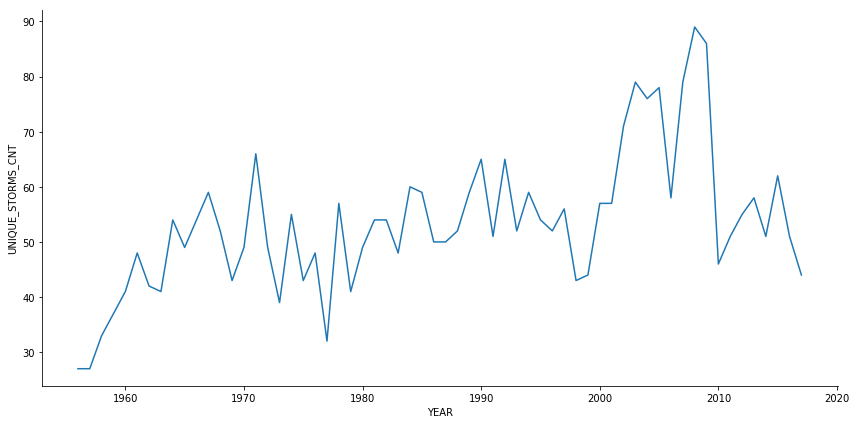

In [29]:
df = data[['YEAR', 'NAME']].drop_duplicates()
df = df.groupby(['YEAR']).count()['NAME'].reset_index()
df = df.rename(index=str, columns={"NAME": "UNIQUE_STORMS_CNT"})

sns.relplot(x="YEAR", y="UNIQUE_STORMS_CNT", data=df, kind = "line", height=6, aspect=2);

#### We can see from the above plot that the rate of increase number of unique storms through the years 2000 to 2010 and then reduce to the same rate as between the years 1950 to 1990. But, we cannot assume that the number of storms increased every year, we need to look at other factors aswell, correlation of other variables as well. 

### Plot of unique storms per region

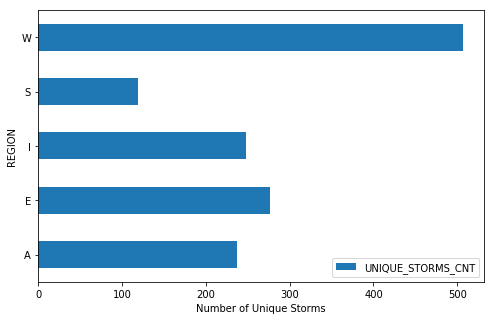

In [30]:
df2 = data[['REGION', 'NAME']].drop_duplicates()
df2 = df2.groupby(['REGION']).count()['NAME'].reset_index()
df2 = df2.rename(index=str, columns={"NAME": "UNIQUE_STORMS_CNT"})
df2.set_index('REGION', inplace = True)
df2.plot(kind="barh", figsize=(8, 5));
plt.ylabel("REGION");
plt.xlabel("Number of Unique Storms");

#### We can see that the number of unique storms in the region "W" are much higher than the other regions, and the reigon "S" has the least number of unique storms, while the rest of the regions had almost equal number of storms.

### Plot of distribution of Unique Storms over the years for every region

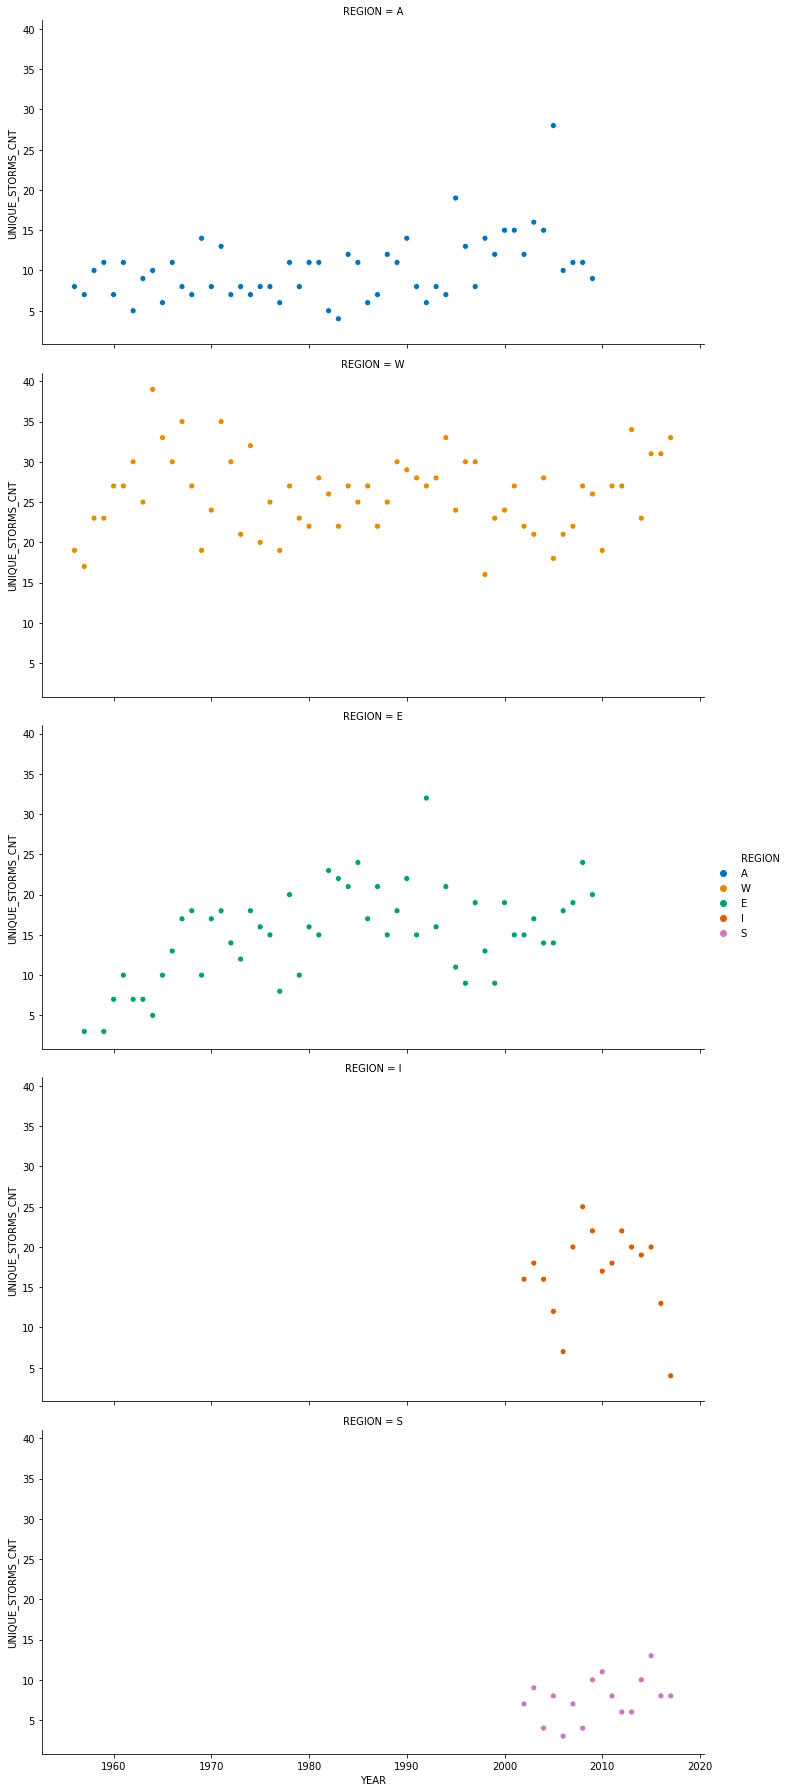

In [31]:
df = data[['YEAR', 'REGION', 'NAME']].drop_duplicates()
df = df.groupby(['YEAR', 'REGION']).count()['NAME'].reset_index()
df = df.rename(index=str, columns={"NAME": "UNIQUE_STORMS_CNT"})

sns.relplot(x="YEAR", y="UNIQUE_STORMS_CNT", hue="REGION", row="REGION", data=df, height=5, aspect=2, palette ='colorblind');

#### From the above plot we can see that region "A" had 5 to 15 unique storm each year from 1950 to 2010.

#### From the above plot we can see that region "W" had higest number of storms ranging from 15 to 40 each year from 1950 to 2017.

#### And, for region "E" we see a steady increase in number of storms each year from 1950 to 2010 and the storm count ranged from 3 to 25.

#### For regions "I" and "S" we see that the number of storms have been recorded for the years 2010 and 2017 only and that the region "I" had more storms than for region "S".

### Histogram of region wise storms per year

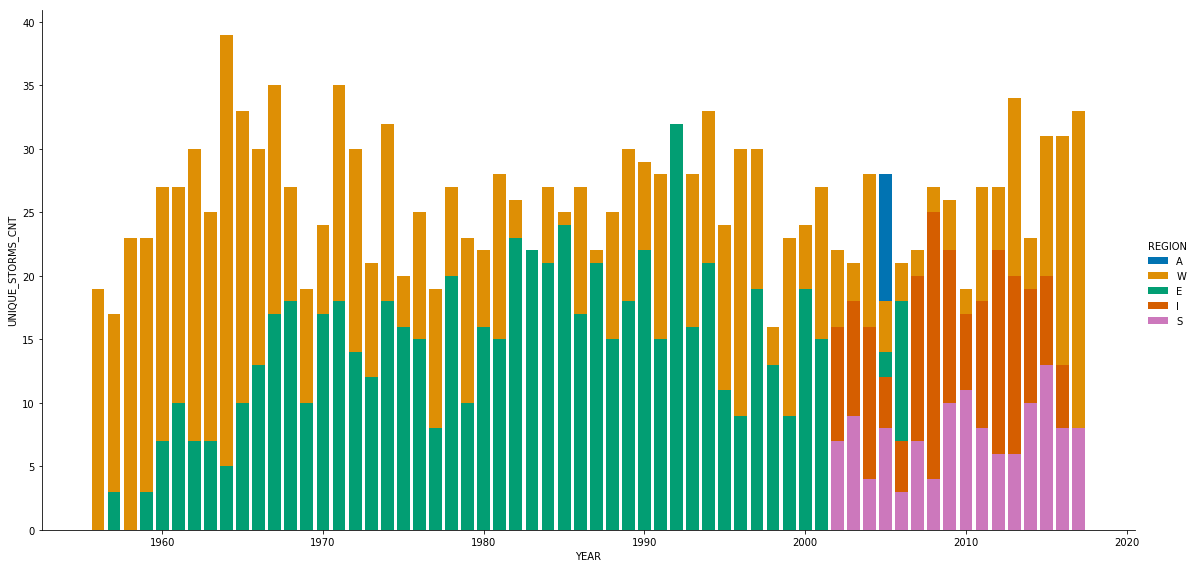

In [36]:
REGION = df.REGION.drop_duplicates()
g = sns.FacetGrid(df, hue="REGION", hue_order=REGION, height=8, aspect=2, palette='colorblind'); 
g.map(plt.bar, 'YEAR', 'UNIQUE_STORMS_CNT').add_legend();

#### On checking the histogram of unique storm count for the five regions, we find that the storms in the region W, were higher than the storms in region E during the years 1950 to 1965 and decreased during the years 1965 to 1994. It says that the regions W and E had higher number of storms during 1950 and 2000.

#### We can find a similar observatin between regions I and S, the number of storms in region I are greater than the ones in region S, and that the storms could be observed begtween 2001 and 2017.

In [34]:
data.TYPE[data.TYPE == ' '].shape

(0,)

### Plot of distribution of unique storms over the years for every region for every type of storm

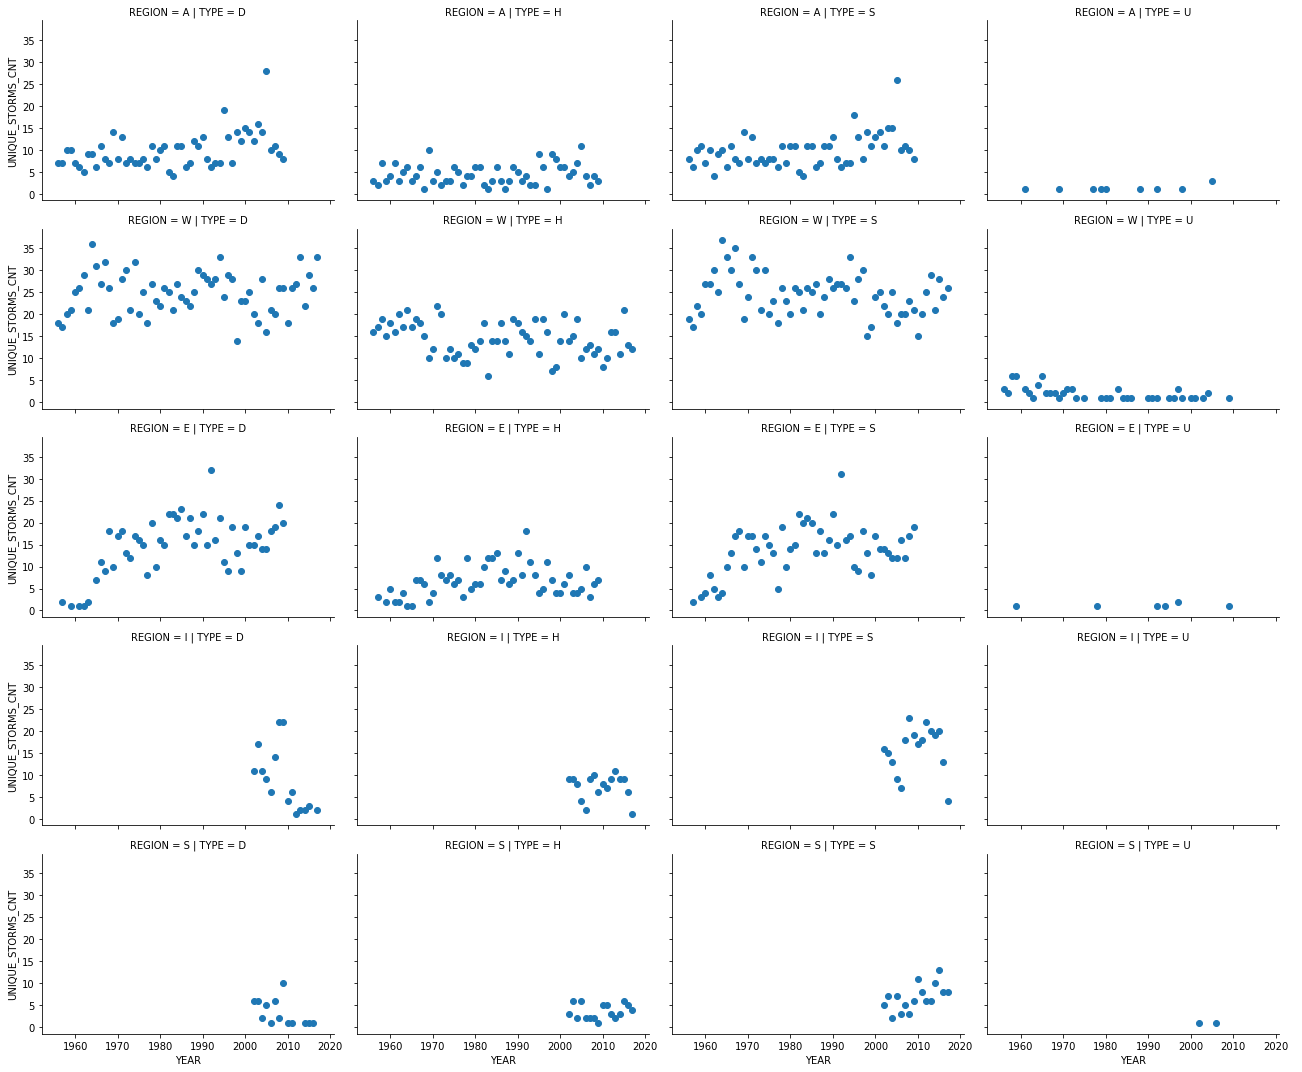

In [37]:
df = data[['YEAR', 'REGION', 'NAME', 'TYPE']].drop_duplicates()
df = df.groupby(['YEAR', 'REGION', 'TYPE']).count()['NAME'].reset_index()
df = df.rename(index=str, columns={"NAME": "UNIQUE_STORMS_CNT"})

grid = sns.FacetGrid(df, col="TYPE", row="REGION", height=3, aspect = 1.5);
grid.map(plt.scatter, "YEAR", "UNIQUE_STORMS_CNT" ).add_legend();

#### In this pair wise plot we can clearly observe the four different types of storm distribution over the five different regions

#### We can clearly see that the storm type "U" is very infrequent in all the regions, with other storm types almost equally frequent in all the regions.

### Plot of relation between Pressure and Speed

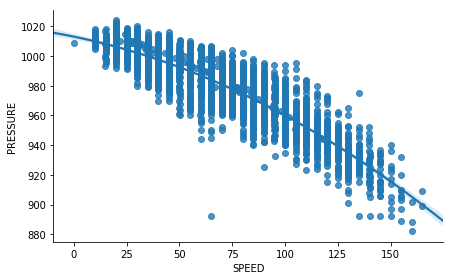

In [38]:
df = data[['SPEED', 'REGION', 'TYPE', 'PRESSURE']].drop_duplicates()
df = df[(df.PRESSURE != 0) & (df.PRESSURE > 800) & (df.PRESSURE < 1800) ]
sns.lmplot(x="SPEED", y="PRESSURE", data=df, x_jitter=.05, order=2, height=4, aspect=1.6); 

#### We can see that as the speed increases the pressure decreases and we need to find its effect on the storm types.

### Linear model fit of speed and pressure categories along with their individual distribution

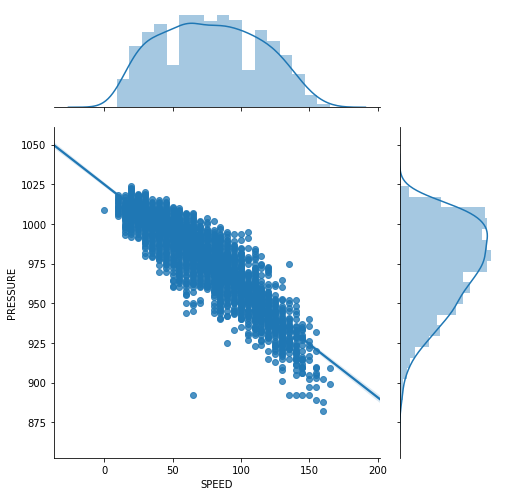

In [39]:
sns.jointplot(x="SPEED", y="PRESSURE", data=df, kind="reg", height=7, ratio=3);

#### When we plot the same linear relationship plot between speed and pressure along with their distributions, we can see that the pressure distribution looks more normal.

### Speed and Pressure distribution for each region and type of storms

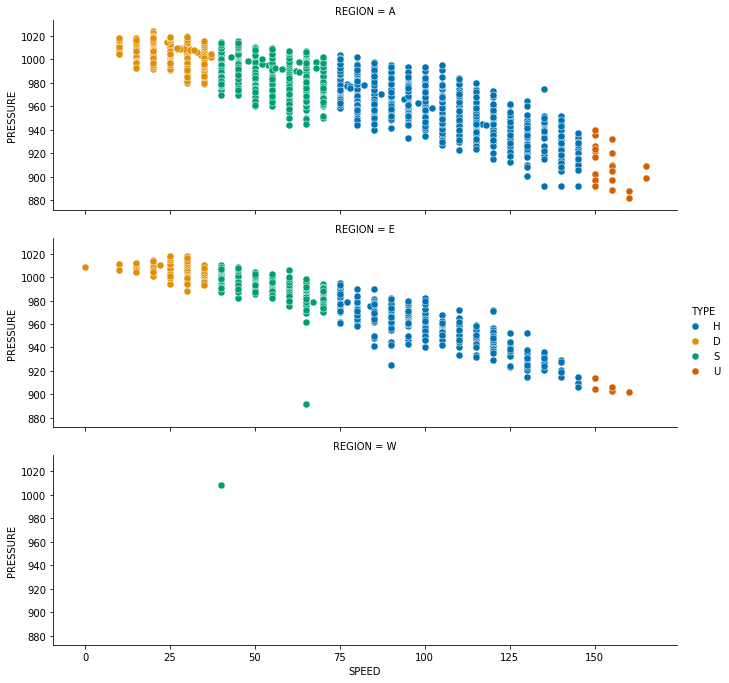

In [40]:
TYPE = df.TYPE.drop_duplicates()
fg = sns.FacetGrid(data=df, row="REGION", hue='TYPE', hue_order=TYPE, height=3.2, aspect=3, legend_out = True, palette = 'colorblind');
kws = dict(s=50, linewidth=.5, edgecolor="w");
fg.map(plt.scatter, 'SPEED', 'PRESSURE', **kws).add_legend();

#### We can observe that the type "D" storms are of higher pressure and lower speed and storm type U is of lower pressure and higher speed.

#### We also observe that the storms of type "S" are more prevalent in region W when compared to other types of storms.

### Draw the storms distributions on a map

In [41]:
import folium
from folium import plugins
from folium.plugins import HeatMap

### Get the locations grouped by Latitude and Longitude

In [42]:
locations = data.groupby(["LAT", "LONG"]).first().reset_index()
locations.shape

(26679, 12)

In [43]:
locations = locations.loc[:, ["TYPE", "REGION", "LAT", "LONG", "NAME", "YEAR"]].drop_duplicates()
locations = locations.sort_values(by=['LAT', 'LONG', 'NAME'])
locations.head(), locations.shape

(  TYPE REGION   LAT   LONG    NAME  YEAR
 0    S      S -34.4  176.9     IVY  2004
 1    D      I -34.3    0.0    CELA  2003
 2    D      I -33.8   62.4  GERARD  2005
 3    D      S -33.5 -160.7    OLAF  2005
 4    S      I -32.0   61.4    GAEL  2009, (26679, 6))

In [44]:
data.TYPE.drop_duplicates().values.tolist()

['S', 'H', 'D', 'U']

### Get unique region codes into a variable

In [45]:
REGION = data.REGION.drop_duplicates().values.tolist()
REGION

['A', 'W', 'E', 'I', 'S']

### Assign color to each type of storm

In [46]:
TYPE_COLOR = {"S": 'red', "H": 'blue', "D": 'yellow', "U": 'white'}

### Function to show scatter plot of storm distributions over a region

In [47]:
def scatter_plot(locations, region, TYPE_COLOR):

    feature_S = folium.FeatureGroup(name = 'S')
    feature_H = folium.FeatureGroup(name = 'H')
    feature_D = folium.FeatureGroup(name = 'D')
    feature_U = folium.FeatureGroup(name = 'U')

    features = {"S": feature_S, "H": feature_H, "D": feature_D, "U": feature_U}

    subset = locations[locations["REGION"] == region].drop_duplicates()
    subset = subset.sample(n = 500)
    subset = subset.reset_index(drop=True)

    folium_map = folium.Map(location=[subset["LAT"][0], subset["LONG"][0]],
                            zoom_start=2,
                            tiles="CartoDB dark_matter")

    for index, row in subset.iterrows():
        radius = subset[subset.NAME == row['NAME']].shape[0]/10
        color = TYPE_COLOR[row["TYPE"]]
        folium.CircleMarker(location=(row["LAT"],
                                      row["LONG"]),
                            radius= 1, # radius,
                            color=color,
                            fill=True).add_to(features[row["TYPE"]])

    folium_map.add_child(feature_S)
    folium_map.add_child(feature_H)
    folium_map.add_child(feature_D)
    folium_map.add_child(feature_U)

    folium_map.add_child(folium.map.LayerControl())

    return folium_map

In [48]:
def scatter_basin_plot(locations, region, TYPE_COLOR, TYPE):
    

    feature_S = folium.FeatureGroup(name = 'S')
    feature_H = folium.FeatureGroup(name = 'H')
    feature_D = folium.FeatureGroup(name = 'D')
    feature_U = folium.FeatureGroup(name = 'U')

    features = {"S": feature_S, "H": feature_H, "D": feature_D, "U": feature_U}

    subset = locations[(locations["REGION"] == region) & (locations["TYPE"] == TYPE)].drop_duplicates()
    subset = subset.sample(n = 500)
    subset = subset.reset_index(drop=True)

    folium_map = folium.Map(location=[subset["LAT"][0], subset["LONG"][0]],
                            zoom_start=2,
                            tiles="CartoDB dark_matter")

    for index, row in subset.iterrows():
        radius = subset[subset.NAME == row['NAME']].shape[0]/10
        color = TYPE_COLOR[row["TYPE"]]
        folium.CircleMarker(location=(row["LAT"],
                                      row["LONG"]),
                            radius= 1, # radius,
                            color=color,
                            fill=True).add_to(features[row["TYPE"]])

    folium_map.add_child(feature_S)
    folium_map.add_child(feature_H)
    folium_map.add_child(feature_D)
    folium_map.add_child(feature_U)

    folium_map.add_child(folium.map.LayerControl())

    return folium_map

### Function to Heat Map for different regions

In [49]:
def heat_map(locations, region):
    subset = locations[locations["REGION"] == region].drop_duplicates()
    subset = subset.sample(n = 500)
    subset = subset.reset_index(drop=True)

    fmap = folium.Map(location=[subset["LAT"][0], subset["LONG"][0]],
                            zoom_start=2)

    subset['LAT'] = subset['LAT'].astype(float)
    subset['LONG'] = subset['LONG'].astype(float)

    df = subset
    df = df[['LAT', 'LONG']]
    df = df.dropna(axis=0, subset=['LAT','LONG'])

    data = [[row['LAT'],row['LONG']] for index, row in df.iterrows()]

    HeatMap(data).add_to(fmap)

    # Display the map
    return fmap

### Scatter Plot for storm types for the region "A", each type can be selected from the drop down to the right

In [50]:
scatter_plot(locations, 'A', TYPE_COLOR)

### HEAT MAP for storm types for the region "A"

In [51]:
heat_map(locations, 'A')

### Scatter Plot for storm types for the region "W", each type can be selected from the drop down to the right

In [52]:
scatter_plot(locations, 'W', TYPE_COLOR)

### HEAT MAP for storm types for the region "W"

In [53]:
heat_map(locations, 'W')

### Scatter Plot for storm types for the region "E", each type can be selected from the drop down to the right

In [54]:
scatter_plot(locations, 'E', TYPE_COLOR)

### HEAT MAP for storm types for the region "E"

In [55]:
heat_map(locations, 'E')

### Scatter Plot for storm types for the region "I", each type can be selected from the drop down to the right

In [56]:
scatter_plot(locations, 'I', TYPE_COLOR)

### Heat Map for storm types for the region "I"

In [57]:
heat_map(locations, 'I')

### Scatter Plot for storm types for the region "S", each type can be selected from the drop down to the right

In [58]:
scatter_plot(locations, 'S', TYPE_COLOR)

### HEAT MAP for storm types for the region "S"

In [59]:
heat_map(locations, 'S')

### Scatter Plot for Region "A" and Storm TYPE "S"

In [60]:
scatter_basin_plot(locations, "A", TYPE_COLOR, "S")